In [1]:
# =============================================================================
# 
# =============================================================================


# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from scipy.stats import  loguniform
import pandas as pd
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from src.features.add_features import features_graph, features_pop
from src.utils.help_func import results_searchcv, make_train_val_test
from sklearn.pipeline import Pipeline
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.regressor import ResidualsPlot
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Path to save the model
# PATH =  f"{root_project}/models/linear_regression_rev17.pkl"

# Read data
df_i = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide_static.csv')
# Load features
df_i = features_graph(df_i)
df_i = features_pop(df_i)

df = df_i.copy()

# size_data = 20000 # enter  desired subset of data
# df = df.sample(size_data)

features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']

# features = [
#     'Tr',
#     'inf_pow_1',
#     'inf_pow_2',
#     'mort_pow_2',
#     'mort_pow_3',
#     'n_closed',
#     'react_time',
#     'total_deceased',
#     'country_pop']

df = df[features]
df

,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,n_closed,react_time,total_deceased,betweenness,degree,closeness,country_pop
0,21.671765,0.000000,0.000000,0.000000,0.000000,0.000000,0,13,0.000000e+00,0.000000,0.045045,0.386760,6465513.0
1,17.728633,23.071429,49.500000,0.445820,0.727273,3.891892,18,30,3.332951e+09,0.000000,0.081081,0.378194,631636.0
2,10.894668,1162.785714,2241.777778,0.195651,0.157861,1.262386,18,23,4.940972e+09,0.000288,0.072072,0.405109,14439018.0
3,22.770250,0.000000,0.000000,0.000000,0.000000,0.000000,5,7,0.000000e+00,0.000072,0.063063,0.391534,1308974.0
4,28.228049,1.214286,1.000000,0.823529,7.000000,7.000000,5,24,5.074933e+06,0.009627,0.387387,0.526066,33699947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78799,20.028500,46.785714,35.562500,0.213740,0.246046,1.428571,18,12,2.155893e+08,0.000184,0.085586,0.405850,17247807.0
78800,16.916117,2.928571,5.500000,0.658537,2.454545,4.500000,18,24,6.462500e+05,0.000788,0.288288,0.486842,1926542.0
78801,14.254116,0.000000,0.000000,0.000000,0.000000,0.000000,12,8,0.000000e+00,0.000464,0.063063,0.323615,71808.0
78802,25.001036,1.000000,0.000000,1.000000,0.000000,14.000000,9,28,1.153780e+05,0.000126,0.234234,0.448485,2789533.0


In [3]:
X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)

pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('estimator', SGDRegressor())
])

param_dist = dict(
    estimator__loss = ['squared_loss', 'huber'],
    estimator__penalty=['l2', 'l1'],
    estimator__alpha = loguniform(0.00001, 1)
)


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   verbose=1, n_iter=50, 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train_val, y_train_val)
# joblib.dump(random_search, PATH)

# Load a model in path
# random_search = joblib.load(PATH)

# Prints out useful information about the model
results_searchcv(random_search, X_test, y_test)

Train_validation set: (63044, 12)
Test set: (15760, 12)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.0min finished


Cross-val best score:
0.18484696061164885
Cross-val std:
0.0020590799026392248
Best parameters found:
{'estimator__alpha': 0.2729378165037475, 'estimator__loss': 'squared_loss', 'estimator__penalty': 'l2'}
Score in test:
0.1853580537991113
R^2 in test
0.1853580537991113
MAE in test:
1777243781.020476


/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


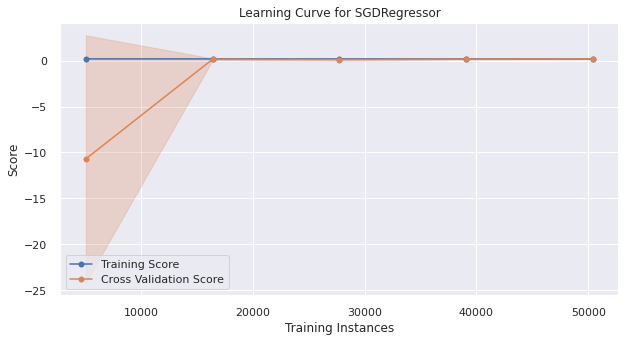

<AxesSubplot:title={'center':'Learning Curve for SGDRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [4]:
# Plot learning curves
fig, ax = plt.subplots(1, 1, figsize = (10,5))
visualizer = LearningCurve(random_search.best_estimator_, scoring='r2')
visualizer.fit(X_train_val, y_train_val)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


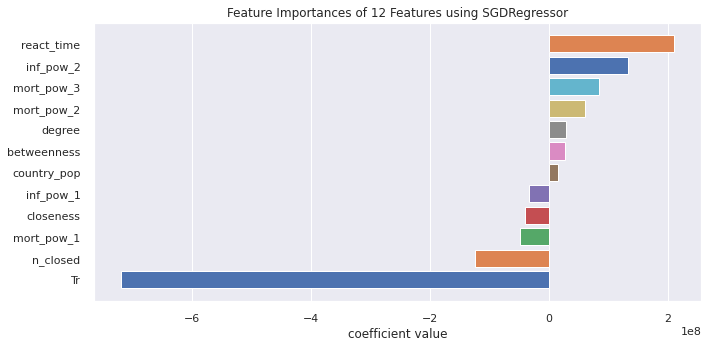

<AxesSubplot:title={'center':'Feature Importances of 12 Features using SGDRegressor'}, xlabel='coefficient value'>

In [5]:
# Plot feature importances
fig, ax = plt.subplots(1, 1, figsize = (10,5))
viz = FeatureImportances(random_search.best_estimator_['estimator'], relative=False)
viz.fit(X_train_val, y_train_val)
viz.show()

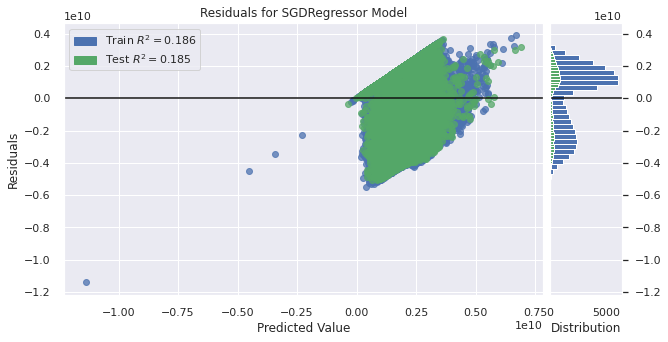

<AxesSubplot:title={'center':'Residuals for SGDRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
# Plot residual plots
fig, ax = plt.subplots(1, 1, figsize = (10,5))
viz = ResidualsPlot(random_search.best_estimator_)
viz.fit(X_train_val, y_train_val)
viz.score(X_test, y_test)
viz.show()

## LOG TARGET

In [40]:
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from scipy.stats import uniform, expon, randint, truncexpon


df_2 = df_i.copy()

features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']

df_2 = df_2[features]

df_2['total_deceased'] = df_2['total_deceased'].replace(0,np.finfo(float).eps)

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df_2, out_mode=1)

Train_validation set: (63044, 12)
Test set: (15760, 12)


In [41]:
reg_trans = TransformedTargetRegressor(
    regressor=SGDRegressor(),
    transformer=QuantileTransformer(n_quantiles=1000,
                                    output_distribution='normal'))
pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('estimator', reg_trans)
])


param_dist = dict(
    estimator__regressor__loss = ['squared_loss'],
    estimator__regressor__penalty=['l2', 'l1'],
    estimator__regressor__alpha = loguniform(0.00001, 1)
)



random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   verbose=1, n_iter=100, 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.6s finished


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocess', StandardScaler()),
                                             ('estimator',
                                              TransformedTargetRegressor(regressor=SGDRegressor(),
                                                                         transformer=QuantileTransformer(output_distribution='normal')))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__regressor__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0905be2b50>,
                                        'estimator__regressor__loss': ['squared_loss'],
                                        'estimator__regressor__penalty': ['l2',
                                                                          'l1']},
                   random_state=42, verbose=1)

In [42]:
results_searchcv(random_search, X_test, y_test)

Cross-val best score:
-0.593919642186029
Cross-val std:
0.030647615505616906
Best parameters found:
{'estimator__regressor__alpha': 0.013076473382928538, 'estimator__regressor__loss': 'squared_loss', 'estimator__regressor__penalty': 'l1'}
Score in test:
-0.49444444915555796
R^2 in test
-0.49444444915555796
MAE in test:
1802101750.107909


/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


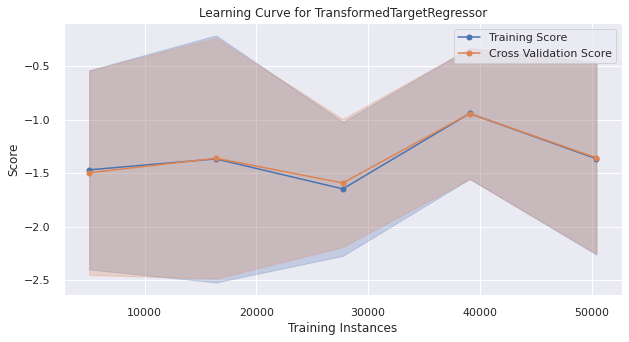

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [43]:
# Plot learning curves
fig, ax = plt.subplots(1, 1, figsize = (10,5))
visualizer = LearningCurve(random_search.best_estimator_, scoring='r2')
visualizer.fit(X_train_val, y_train_val)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

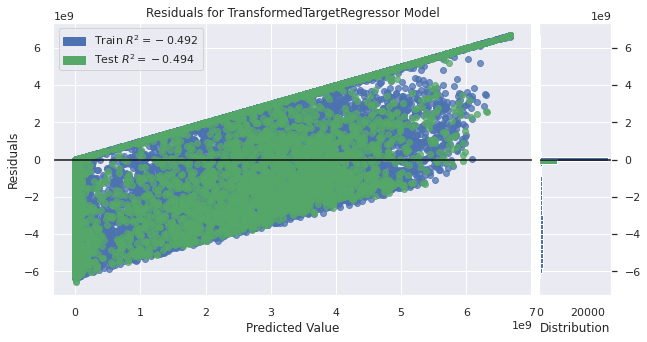

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [44]:
# Plot residual plots
fig, ax = plt.subplots(1, 1, figsize = (10,5))
viz = ResidualsPlot(random_search.best_estimator_)
viz.fit(X_train_val, y_train_val)
viz.score(X_test, y_test)
viz.show()